In [ ]:
'''
SimpleGAN 

This notebook is meant to be a simple GAN example for numeric info 
(maybe image and text examples also)
'''

In [35]:
import torch 
import torch.nn as nn
import math 
import matplotlib.pyplot as plt

the first numeric GAN example will be generating sine numerics 
the GAN will generate (x1, x2) numbers from random input 

In [16]:
#create the training data for the GAN to learn its latent space 
x_input = torch.rand(1000)
y_output = torch.sin(2 * math.pi * x_input)

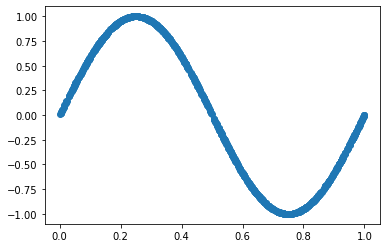

In [17]:
plt.scatter(x_input, y_output)

In [27]:
#save the input and output tensors as a tensor
training_set = torch.zeros(len(x_input), 2)

In [28]:
training_set[:, 0] = x_input

In [29]:
training_set[:, 1] = y_output

In [30]:
training_set

tensor([[ 0.4469,  0.3275],
        [ 0.1304,  0.7308],
        [ 0.7953, -0.9597],
        ...,
        [ 0.0802,  0.4827],
        [ 0.1822,  0.9106],
        [ 0.3180,  0.9100]])

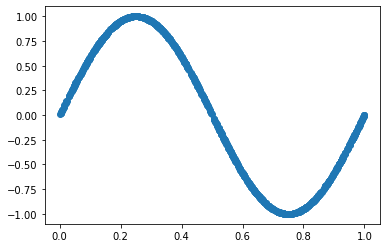

In [32]:
#verify the training set tensor is correct 
plt.scatter(training_set[:, 0], training_set[:, 1])

In [54]:
#create the data loader from torch.utils to handle batching the data 
#this dataset is used to calculate the generator's loss
training_data = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True)

In [33]:
#create a random generator to match the dimensions of the output (x1, x2)
#we need this random noise for the GAN to use as input
def get_random_noise(z_dim):
    return torch.randn((z_dim, 2))

In [45]:
#create the generator 
#the first layer is a 2 for the 2 dimensions of the input data (x1, x2)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32), 
            nn.ReLU(), 
            nn.Linear(32, 64), 
            nn.ReLU(), 
            nn.Linear(64, 128), 
            nn.ReLU(), 
            nn.Linear(128, 2))
        
    def forward(self, data):
        return self.model(data)

In [107]:
#create the discriminator 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), 
            nn.ReLU(), 
            nn.Linear(256, 128), 
            nn.ReLU(), 
            nn.Linear(128, 64), 
            nn.ReLU(), 
            nn.Linear(64, 1), 
            nn.Sigmoid())
        
    def forward(self, data):
        return self.model(data)

In [108]:
gen = Generator()
disc = Discriminator()

In [109]:
loss = nn.BCELoss()
lr = 0.0001
batch_size = 25
epochs = 1000

In [110]:
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [111]:
#loop through the entire dataset [epoch] number of times
for i in range(0, epochs):
    #for each batch, train and update the models
    for n, samples in enumerate(training_data):
        #the training data is the REAL data, the fake data is randomly generated
        #label the real samples from the batch as real with a 1
        fake_output = gen(get_random_noise(len(samples)))
        fake_labels = torch.zeros((len(samples), 1))
        real_labels = torch.ones((len(samples), 1))
        all_samples = torch.cat((samples, fake_output))
        all_labels = torch.cat((real_labels, fake_labels))
        
        #get the discriminator's predictions first 
        disc.zero_grad()
        disc_output = disc(all_samples)
        #the loss needs to have the model output first 
        disc_loss = loss(disc_output, all_labels)
        disc_loss.backward()
        disc_opt.step()
        
        #train the generator
        gen.zero_grad()
        gen_output = gen(get_random_noise(len(samples)))
        #we want the genertor to be corrected based on feedback from the discriminator
        #in order to correct it, we want the generator lables to "appear" real so we use the
        #real label for the generator when calculating the loss
        gen_loss = loss(disc(gen_output), real_labels)
        gen_loss.backward()
        gen_opt.step()
        
        print (disc_loss.item(), gen_loss.item())

0.6906726956367493 0.704315185546875
0.6887566447257996 0.7058260440826416
0.6870536208152771 0.7072032690048218
0.684934139251709 0.7086461782455444
0.6834774017333984 0.7101220488548279
0.6818450689315796 0.7114527821540833
0.678809404373169 0.712618887424469
0.6771417260169983 0.7138382792472839
0.6752059459686279 0.7149690389633179
0.6752340793609619 0.7162322998046875
0.6733962893486023 0.7174960970878601
0.6699079275131226 0.7186963558197021
0.6695718169212341 0.7199312448501587
0.667439877986908 0.7212477922439575
0.6660357117652893 0.7225357890129089
0.6656230092048645 0.7236130237579346
0.6646764874458313 0.7245635986328125
0.6607860326766968 0.7259150147438049
0.6592613458633423 0.7273167371749878
0.6576061844825745 0.7285754680633545
0.6572042107582092 0.7301976680755615
0.6537465453147888 0.7307058572769165
0.6539086103439331 0.7327689528465271
0.6509623527526855 0.7338871955871582
0.6501598358154297 0.735481321811676
0.6474562287330627 0.7367753386497498
0.6451078057289124

0.47152844071388245 1.1770589351654053
0.45404165983200073 1.2028924226760864
0.4378013610839844 1.1741478443145752
0.5006720423698425 1.2144362926483154
0.43809741735458374 1.195052981376648
0.4799538850784302 1.1538872718811035
0.5074179172515869 1.0829055309295654
0.5525789856910706 1.1559251546859741
0.5480285882949829 1.1263729333877563
0.4994489252567291 1.1053677797317505
0.5483123064041138 1.1963199377059937
0.5309948921203613 1.126940131187439
0.5605024099349976 1.1396417617797852
0.48627209663391113 1.1013237237930298
0.5293816328048706 1.0952149629592896
0.5522021651268005 1.081709384918213
0.5170157551765442 1.1223832368850708
0.5307393074035645 1.0709271430969238
0.5438033938407898 1.0952917337417603
0.5783563852310181 1.0760613679885864
0.5526991486549377 1.0764232873916626
0.594027578830719 1.0918126106262207
0.6155260801315308 1.0572360754013062
0.6656957268714905 1.070582628250122
0.6084357500076294 1.0142637491226196
0.6065550446510315 1.0012128353118896
0.62713128328

0.684886634349823 0.9645748138427734
0.685151994228363 0.9389413595199585
0.6762740612030029 0.9240814447402954
0.6585071682929993 0.934517502784729
0.6128717660903931 0.9493091106414795
0.6775415539741516 0.9522566199302673
0.6814985871315002 0.9626922607421875
0.6706749200820923 0.9472064971923828
0.6719822883605957 0.9512081742286682
0.6755627989768982 0.9020532965660095
0.6781349182128906 0.9741687774658203
0.6690441966056824 0.9079944491386414
0.6702971458435059 0.9230731129646301
0.6778547763824463 0.8852152824401855
0.6608332991600037 0.9103426933288574
0.6798503994941711 0.8651317358016968
0.6747338771820068 0.8991265296936035
0.6493561267852783 0.9312421679496765
0.6902191638946533 0.8776593804359436
0.6623889803886414 0.8897420763969421
0.6788351535797119 0.8680694699287415
0.6761927604675293 0.8745911121368408
0.675581157207489 0.8670191168785095
0.658455491065979 0.8508309125900269
0.6810847520828247 0.8737980127334595
0.6840788125991821 0.8498148322105408
0.667857587337493

0.6572679281234741 0.7379022836685181
0.669646680355072 0.7610839009284973
0.6721449494361877 0.7583678364753723
0.676247775554657 0.7435559034347534
0.6599473357200623 0.7388325333595276
0.6728180050849915 0.7536566257476807
0.6649633049964905 0.7526247501373291
0.6744335889816284 0.7617546916007996
0.6624960899353027 0.7451556324958801
0.654609203338623 0.75032639503479
0.646628737449646 0.756357729434967
0.6599140167236328 0.7654255032539368
0.6616783738136292 0.7411420941352844
0.6745591163635254 0.7541958093643188
0.6719869375228882 0.749922513961792
0.6757978200912476 0.7468553185462952
0.6539003252983093 0.7360202074050903
0.6609910726547241 0.7459279894828796
0.6609034538269043 0.742201030254364
0.6507081389427185 0.7489759922027588
0.6734705567359924 0.731231689453125
0.669594943523407 0.7485978603363037
0.6665878891944885 0.7543996572494507
0.6665251851081848 0.7539886236190796
0.6719632148742676 0.7575327157974243
0.6749486327171326 0.7812822461128235
0.6504398584365845 0.73

0.6774896383285522 0.719785213470459
0.6730065941810608 0.7565435767173767
0.6840194463729858 0.7127801775932312
0.6776140332221985 0.7562301754951477
0.6791529655456543 0.7214540839195251
0.6711905002593994 0.7335053086280823
0.6851511597633362 0.7555521130561829
0.6656778454780579 0.7454014420509338
0.6754697561264038 0.7544062733650208
0.6710231900215149 0.7087729573249817
0.6832330822944641 0.736449122428894
0.6819899678230286 0.7313074469566345
0.6782981753349304 0.7069171667098999
0.6724637746810913 0.7218626141548157
0.6841503977775574 0.7526184916496277
0.6792795062065125 0.696014404296875
0.6842615604400635 0.7317766547203064
0.6678134202957153 0.7109150886535645
0.6698798537254333 0.7287480235099792
0.6751444339752197 0.7499454021453857
0.6730424761772156 0.72980797290802
0.6776278018951416 0.7270447611808777
0.6808454394340515 0.7115629315376282
0.6838839650154114 0.7231423854827881
0.6780117750167847 0.7364035844802856
0.6897024512290955 0.7187339067459106
0.685522556304931

0.6790900230407715 0.7034438848495483
0.6802189350128174 0.7240720987319946
0.6802923679351807 0.7125160098075867
0.6837791204452515 0.7179692983627319
0.6801049113273621 0.7090277671813965
0.6864165663719177 0.71205735206604
0.6837504506111145 0.731570303440094
0.6804094910621643 0.7212780714035034
0.6807506680488586 0.7159592509269714
0.6845912337303162 0.7123978137969971
0.6767497062683105 0.7158995270729065
0.6739147305488586 0.7261142134666443
0.6773632764816284 0.7093780040740967
0.673804521560669 0.7086053490638733
0.6740220785140991 0.6983364820480347
0.6825375556945801 0.7191410660743713
0.6697445511817932 0.715284526348114
0.6833972334861755 0.7046650648117065
0.6840476989746094 0.7054660320281982
0.6841335296630859 0.7134841680526733
0.6751834750175476 0.7155783772468567
0.6796087622642517 0.6977117657661438
0.6794266700744629 0.7149533629417419
0.6808393597602844 0.7155944108963013
0.6813512444496155 0.7114021182060242
0.6834489703178406 0.7191212177276611
0.681390702724456

0.6794005632400513 0.7055844068527222
0.6848189830780029 0.7026109099388123
0.6851372718811035 0.6993730664253235
0.6843447685241699 0.7009598612785339
0.6879615783691406 0.7060083746910095
0.6835533380508423 0.7050625085830688
0.6724709868431091 0.6954920887947083
0.6752825379371643 0.7038339376449585
0.6786211133003235 0.6989089250564575
0.6738144755363464 0.7007657885551453
0.678749680519104 0.7021478414535522
0.6725819110870361 0.7039437294006348
0.6704385280609131 0.7071279883384705
0.6635735034942627 0.7087450623512268
0.672684907913208 0.702232837677002
0.6603270769119263 0.6982827186584473
0.6661725640296936 0.704896092414856
0.661994993686676 0.7078461647033691
0.6658678650856018 0.705211341381073
0.6623371243476868 0.7114993929862976
0.6585038900375366 0.7162424325942993
0.654704213142395 0.7069159746170044
0.655588686466217 0.699678361415863
0.6558840870857239 0.7028111219406128
0.6642558574676514 0.717047929763794
0.6621808409690857 0.710512638092041
0.6674431562423706 0.70

0.6897798180580139 0.7114930152893066
0.6693153381347656 0.7005579471588135
0.6589090824127197 0.7436037659645081
0.6725367903709412 0.7371456623077393
0.7030062079429626 0.6989124417304993
0.6771758198738098 0.7467830181121826
0.6859256625175476 0.7186238765716553
0.6861250996589661 0.7304801940917969
0.6923061609268188 0.7042433023452759
0.6892198920249939 0.7329036593437195
0.706188976764679 0.7352840900421143
0.6761353015899658 0.7387818098068237
0.6965602040290833 0.7180615067481995
0.6983231902122498 0.7247515916824341
0.6765062212944031 0.734326183795929
0.6981738805770874 0.7069780826568604
0.7045583128929138 0.7329593896865845
0.702964186668396 0.7464084625244141
0.6911733150482178 0.7687584757804871
0.6897629499435425 0.7349523901939392
0.6985887885093689 0.7258757948875427
0.6900230646133423 0.7285205125808716
0.7088980078697205 0.7274311780929565
0.7093870639801025 0.7251271605491638
0.7060459852218628 0.7228568196296692
0.69044029712677 0.708497941493988
0.6987201571464539

0.6667799949645996 0.7193642258644104
0.6687395572662354 0.7208640575408936
0.6730356812477112 0.7235835790634155
0.6759316325187683 0.7209094166755676
0.6710959076881409 0.7263692617416382
0.6785571575164795 0.7246458530426025
0.6732425093650818 0.7341376543045044
0.6800540685653687 0.7297251224517822
0.6744970679283142 0.7310936450958252
0.6765477061271667 0.7333279252052307
0.675523042678833 0.7254880666732788
0.6817381978034973 0.7334387898445129
0.6798669695854187 0.7374722957611084
0.6765449047088623 0.751295804977417
0.6727048754692078 0.7435572743415833
0.6773552894592285 0.7530869245529175
0.6738162040710449 0.7472631335258484
0.6737387180328369 0.7447502613067627
0.6729365587234497 0.7500490546226501
0.6704047918319702 0.7654838562011719
0.6696072220802307 0.7585437297821045
0.676068127155304 0.7441484332084656
0.674217939376831 0.7412989139556885
0.6761009693145752 0.7453781366348267
0.6605434417724609 0.7516270279884338
0.672201931476593 0.733665943145752
0.6598488688468933

0.7148733735084534 0.7591793537139893
0.7270654439926147 0.7555637955665588
0.7244471907615662 0.7674869298934937
0.7026919722557068 0.8019670248031616
0.7044125199317932 0.7822408080101013
0.7052958607673645 0.8096422553062439
0.6914811730384827 0.7920257449150085
0.6803767681121826 0.8123346567153931
0.6963697671890259 0.8117395043373108
0.6874290704727173 0.7906166315078735
0.7006350755691528 0.7825672626495361
0.6934115886688232 0.786112904548645
0.6655716896057129 0.7800028324127197
0.6535419225692749 0.7721301913261414
0.6633794903755188 0.8038198947906494
0.6563759446144104 0.7904645800590515
0.6725969910621643 0.7811686992645264
0.6734882593154907 0.7950488328933716
0.6487973928451538 0.7922172546386719
0.6489927768707275 0.798317015171051
0.6478632092475891 0.8242086172103882
0.6502352952957153 0.7897673845291138
0.6717499494552612 0.7813267707824707
0.6378089785575867 0.780901312828064
0.6328207850456238 0.7821094393730164
0.6276883482933044 0.7691324353218079
0.6562439799308

0.6579110026359558 0.7240757942199707
0.6678674817085266 0.7282273173332214
0.6642066836357117 0.7307264804840088
0.6746692061424255 0.7131137251853943
0.6859214901924133 0.7155671715736389
0.678619384765625 0.7278174757957458
0.6651108264923096 0.7175721526145935
0.680443525314331 0.7164456248283386
0.6734378933906555 0.7144884467124939
0.6681797504425049 0.7122704386711121
0.6707853674888611 0.7253962755203247
0.6700490713119507 0.720475971698761
0.6688079237937927 0.7304559350013733
0.6746322512626648 0.7372779250144958
0.6832096576690674 0.7292098999023438
0.6682199835777283 0.7407751679420471
0.6727780699729919 0.7264545559883118
0.6801695227622986 0.7283941507339478
0.6727880239486694 0.7298290133476257
0.6563993096351624 0.7354578375816345
0.6709096431732178 0.7160369753837585
0.6783990263938904 0.7324786186218262
0.669026792049408 0.7265426516532898
0.6797566413879395 0.7263458967208862
0.6756088733673096 0.7182334065437317
0.6660830974578857 0.7288177609443665
0.68029922246932

0.6825176477432251 0.6994162797927856
0.7019108533859253 0.6886954307556152
0.6966580152511597 0.6749030947685242
0.6851000785827637 0.6913591027259827
0.6974882483482361 0.6990622878074646
0.6797782778739929 0.6899498105049133
0.6954168677330017 0.6935526132583618
0.688243567943573 0.6914493441581726
0.6880267262458801 0.6860178112983704
0.6901791095733643 0.6896190643310547
0.6910054087638855 0.6869047284126282
0.6856079697608948 0.6900379657745361
0.7021267414093018 0.6757344603538513
0.6787053942680359 0.6983628869056702
0.7010213732719421 0.7028042674064636
0.6883531808853149 0.7104857563972473
0.6873580813407898 0.7082359790802002
0.6917814016342163 0.693389892578125
0.6897895336151123 0.7057235240936279
0.7001897692680359 0.7113690376281738
0.7024775743484497 0.7093814611434937
0.6885215044021606 0.6906670331954956
0.6910176873207092 0.7020215392112732
0.6909559369087219 0.7065260410308838
0.6936691403388977 0.702521800994873
0.6850354075431824 0.6978088617324829
0.6947366595268

0.6831815838813782 0.6886808276176453
0.6972858905792236 0.6898806691169739
0.687379002571106 0.6907915472984314
0.6833356618881226 0.6974058747291565
0.6886742115020752 0.705549418926239
0.6825892925262451 0.7029727101325989
0.6841281652450562 0.7080780267715454
0.6935626864433289 0.717974841594696
0.6850255727767944 0.7132099270820618
0.6924587488174438 0.7123042941093445
0.6876691579818726 0.712109386920929
0.6913303136825562 0.6985839009284973
0.6926097869873047 0.7044426798820496
0.6842643022537231 0.6983874440193176
0.6873553395271301 0.6987326145172119
0.6935209631919861 0.6964457035064697
0.6877477169036865 0.7036904692649841
0.6927211284637451 0.7091922163963318
0.6918973326683044 0.7128818035125732
0.6874473094940186 0.7025672197341919
0.6904073357582092 0.701781690120697
0.6924086809158325 0.7096515893936157
0.6859953999519348 0.7055571675300598
0.685690701007843 0.7079134583473206
0.6887468099594116 0.7020522952079773
0.6862018704414368 0.7091679573059082
0.6886705160140991

0.6925846338272095 0.6897462606430054
0.6922768950462341 0.7023178935050964
0.6781362295150757 0.7065344452857971
0.6915324926376343 0.7029128074645996
0.6926519274711609 0.7185016870498657
0.6877635717391968 0.7211188673973083
0.6910507678985596 0.7089762687683105
0.6872192621231079 0.7179300785064697
0.6847853660583496 0.7237372398376465
0.6882612705230713 0.7189089059829712
0.6798551082611084 0.7125402092933655
0.6839212775230408 0.7157717943191528
0.6867917776107788 0.710384726524353
0.6948873996734619 0.6995121240615845
0.6833751201629639 0.7037194967269897
0.6766325235366821 0.6999621391296387
0.6878160238265991 0.7008486986160278
0.6836062669754028 0.704556941986084
0.6915618181228638 0.7011139392852783
0.6893008947372437 0.7076865434646606
0.686961829662323 0.7114154696464539
0.6839089393615723 0.7061100602149963
0.6878197193145752 0.7128200531005859
0.6793355345726013 0.7111543416976929
0.6825793981552124 0.7230527400970459
0.6872256398200989 0.733548104763031
0.68597906827926

0.6938480138778687 0.695691704750061
0.6820738315582275 0.7043861150741577
0.6882961988449097 0.7016587853431702
0.6878146529197693 0.6954779624938965
0.6891719102859497 0.7127072811126709
0.6866348385810852 0.7180682420730591
0.6886785626411438 0.7101121544837952
0.6862080097198486 0.7113156914710999
0.6895185708999634 0.7028465270996094
0.6820061206817627 0.712740421295166
0.6938422322273254 0.7007943987846375
0.689304530620575 0.713687002658844
0.698991596698761 0.6972012519836426
0.6928176879882812 0.6939669847488403
0.6896640062332153 0.6901643872261047
0.6858416199684143 0.6806942820549011
0.6853753924369812 0.6813840270042419
0.6854163408279419 0.6798229813575745
0.6815397143363953 0.6808884143829346
0.6868953108787537 0.6849485039710999
0.6829426288604736 0.6928319334983826
0.6935927867889404 0.6866750121116638
0.6862033009529114 0.6982683539390564
0.6851150989532471 0.69865882396698
0.68659508228302 0.7062225937843323
0.6921201348304749 0.7102230191230774
0.6855209469795227 0.

0.693122148513794 0.7058852910995483
0.6916564106941223 0.7164848446846008
0.6889114379882812 0.7301794290542603
0.6905237436294556 0.7274426817893982
0.6867755651473999 0.7242603898048401
0.6893594264984131 0.7259388566017151
0.6948034167289734 0.7197990417480469
0.6858218908309937 0.7174047827720642
0.6822959780693054 0.7133274674415588
0.6826444864273071 0.7024434804916382
0.6839814186096191 0.7094941139221191
0.6900559067726135 0.6910037994384766
0.6834053993225098 0.6897519826889038
0.6874801516532898 0.6923598647117615
0.6913007497787476 0.6769422888755798
0.6839212775230408 0.6937462687492371
0.6828067302703857 0.6825419068336487
0.6999839544296265 0.6716372966766357
0.6866446733474731 0.6840154528617859
0.6856529712677002 0.7018564343452454
0.6860435009002686 0.6975157260894775
0.6895940899848938 0.7043044567108154
0.6917486786842346 0.7089933156967163
0.6918337941169739 0.7061307430267334
0.6857285499572754 0.7157856822013855
0.6819157600402832 0.715383768081665
0.685686647891

0.681416392326355 0.7136595249176025
0.6896342635154724 0.7084092497825623
0.6859681010246277 0.7186251878738403
0.6852342486381531 0.7199767231941223
0.6834326982498169 0.7189785242080688
0.6796666979789734 0.7185568809509277
0.6783967018127441 0.7149884104728699
0.6827937364578247 0.7144086360931396
0.6829043030738831 0.7240564823150635
0.6825005412101746 0.7225069403648376
0.685211181640625 0.7009388208389282
0.6754289269447327 0.7171341180801392
0.6779599189758301 0.7008124589920044
0.685953676700592 0.712525486946106
0.6853533387184143 0.7128009796142578
0.6796411275863647 0.7240974307060242
0.6850820779800415 0.7077024579048157
0.6826158761978149 0.6997054219245911
0.6966266632080078 0.7080898880958557
0.6847987174987793 0.6946909427642822
0.68212890625 0.6979265809059143
0.6874948143959045 0.709663450717926
0.7015471458435059 0.6993555426597595
0.6841691732406616 0.6932546496391296
0.6898880004882812 0.6948761940002441
0.6813098788261414 0.6974261403083801
0.6834368109703064 0.6

0.6829010248184204 0.6964305639266968
0.6905021667480469 0.6950896382331848
0.6834901571273804 0.7052274346351624
0.6852868795394897 0.6988617777824402
0.6881607174873352 0.695793867111206
0.6868025064468384 0.699544370174408
0.6837365031242371 0.7147859334945679
0.684619128704071 0.7128053903579712
0.6818994283676147 0.6986659169197083
0.6849238872528076 0.7102017402648926
0.6855133771896362 0.7021546363830566
0.6828557848930359 0.7012119293212891
0.6872910261154175 0.708981990814209
0.6870338916778564 0.7126584649085999
0.686897873878479 0.7098364233970642
0.6859281063079834 0.7103393077850342
0.6856955885887146 0.7204657196998596
0.6900493502616882 0.7116432189941406
0.6877172589302063 0.7164105176925659
0.686369776725769 0.7226251363754272
0.6808372735977173 0.7128313183784485
0.6864147782325745 0.7136358022689819
0.6873721480369568 0.7145784497261047
0.6904929280281067 0.7161348462104797
0.694267749786377 0.7143908739089966
0.6892074346542358 0.7036029696464539
0.6787352561950684 

0.6853223443031311 0.7149876952171326
0.6848760843276978 0.7085882425308228
0.687155544757843 0.7112423181533813
0.6814321279525757 0.7109835147857666
0.6859261393547058 0.7115995287895203
0.6875514388084412 0.7007524967193604
0.6867583990097046 0.7165747880935669
0.6890912055969238 0.7049437165260315
0.6856334209442139 0.7178594470024109
0.688579797744751 0.6957923769950867
0.6851376891136169 0.695054292678833
0.6834373474121094 0.7102310061454773
0.6886215806007385 0.7174879312515259
0.6886090040206909 0.7188910841941833
0.6795381307601929 0.7201410531997681
0.685417115688324 0.7042460441589355
0.6882562041282654 0.7050476670265198
0.6856503486633301 0.7033306956291199
0.6850638389587402 0.7093187570571899
0.6823749542236328 0.6949620246887207
0.6837062239646912 0.6950060129165649
0.6870185732841492 0.6939794421195984
0.6829920411109924 0.6965776681900024
0.6828240156173706 0.6898342967033386
0.6883421540260315 0.6985160112380981
0.6779075860977173 0.710914671421051
0.683191299438476

0.6866176724433899 0.7074892520904541
0.6838477253913879 0.7082979083061218
0.6863547563552856 0.7121202945709229
0.6796736121177673 0.7063125371932983
0.6828992962837219 0.711396336555481
0.6871929168701172 0.7085033655166626
0.6828404068946838 0.7080260515213013
0.6874376535415649 0.7078597545623779
0.6821441650390625 0.7048028707504272
0.68401038646698 0.7022020220756531
0.6839717626571655 0.7037988305091858
0.6881261467933655 0.6965349316596985
0.6820027828216553 0.6913911700248718
0.6836416721343994 0.6933122873306274
0.6843569278717041 0.6996967196464539
0.6845138669013977 0.6972021460533142
0.6842465400695801 0.6957026720046997
0.6830482482910156 0.6998389363288879
0.6833141446113586 0.7011688351631165
0.686595618724823 0.7113985419273376
0.6812569499015808 0.708436131477356
0.6801281571388245 0.7158284783363342
0.6806021332740784 0.7235897779464722
0.6844114065170288 0.7168704271316528
0.6900967955589294 0.7162800431251526
0.6837860345840454 0.7059560418128967
0.680873572826385

0.683866560459137 0.7018244862556458
0.6925435662269592 0.7089245319366455
0.683907687664032 0.7081796526908875
0.6815316677093506 0.7032105922698975
0.686149001121521 0.7092263698577881
0.6858971118927002 0.700198769569397
0.6815670728683472 0.7226542830467224
0.6843826174736023 0.7078139781951904
0.6838147640228271 0.7088971138000488
0.6797473430633545 0.7053499817848206
0.6870935559272766 0.7032503485679626
0.682035505771637 0.7163404822349548
0.6839052438735962 0.7093935608863831
0.680868923664093 0.691658616065979
0.6809861063957214 0.705986499786377
0.6858237981796265 0.6883007884025574
0.6852193474769592 0.6899288892745972
0.679933488368988 0.6951639652252197
0.6874122619628906 0.6977729797363281
0.6836864948272705 0.7013323903083801
0.6851195693016052 0.7012871503829956
0.6812300086021423 0.7060678005218506
0.6824297308921814 0.709694504737854
0.6845370531082153 0.7087905406951904
0.6834114193916321 0.721529483795166
0.6852278709411621 0.7182356119155884
0.6865288019180298 0.72

0.6823441386222839 0.6893191337585449
0.6856255531311035 0.6960594058036804
0.683483362197876 0.7033076286315918
0.6866075992584229 0.7045865654945374
0.6870241761207581 0.7052934169769287
0.6805422902107239 0.7089698910713196
0.6813694834709167 0.7091968655586243
0.6883691549301147 0.7114650011062622
0.681830883026123 0.7021899223327637
0.686858594417572 0.7101238965988159
0.683357834815979 0.7053329944610596
0.6944389343261719 0.7096900343894958
0.6796351671218872 0.7104430198669434
0.6807698607444763 0.7094680666923523
0.6864721179008484 0.7043426036834717
0.6780761480331421 0.7073459029197693
0.679506778717041 0.6971347332000732
0.6860731244087219 0.7034730315208435
0.6895599961280823 0.7050953507423401
0.6844311356544495 0.6955967545509338
0.6862261891365051 0.7047471404075623
0.6835970878601074 0.6986836791038513
0.6842739582061768 0.6962572336196899
0.6819237470626831 0.705515444278717
0.6839869022369385 0.6953678727149963
0.6889853477478027 0.7151482105255127
0.6811994910240173

0.682834267616272 0.6975772976875305
0.6925942897796631 0.7032652497291565
0.6852278709411621 0.703346312046051
0.6900171637535095 0.7031713128089905
0.6833634972572327 0.7011544704437256
0.6775515079498291 0.707090437412262
0.6844626069068909 0.7079930305480957
0.6830335259437561 0.708456814289093
0.686686635017395 0.7133917808532715
0.6862747073173523 0.7118509411811829
0.6898031830787659 0.6911906599998474
0.6877654790878296 0.6902711987495422
0.6878705620765686 0.6862583756446838
0.6877226233482361 0.6806874871253967
0.6826866865158081 0.686525285243988
0.6827141642570496 0.6985756158828735
0.6817334890365601 0.6966821551322937
0.6834744811058044 0.7029244303703308
0.6794848442077637 0.7133797407150269
0.682868242263794 0.7139334678649902
0.6907675862312317 0.7047809362411499
0.6850792169570923 0.7057846784591675
0.6886619329452515 0.7306970357894897
0.6792843341827393 0.7164062261581421
0.694165050983429 0.7054989337921143
0.6861255168914795 0.7043547034263611
0.6830878257751465 0

0.6924854516983032 0.7214081287384033
0.6850559115409851 0.7152281403541565
0.6862176656723022 0.7138276696205139
0.6787043809890747 0.7217601537704468
0.6831883192062378 0.7137812972068787
0.6837618350982666 0.7023400068283081
0.684623122215271 0.6945034861564636
0.6837460994720459 0.6919384598731995
0.6865308284759521 0.6849613785743713
0.6833834052085876 0.6903226971626282
0.6887750029563904 0.6972727179527283
0.6875539422035217 0.7011303901672363
0.6844704151153564 0.7099130153656006
0.6844520568847656 0.7138198614120483
0.6803115606307983 0.716898500919342
0.6871322393417358 0.7151919007301331
0.6825111508369446 0.7255728244781494
0.6844847202301025 0.7138323187828064
0.6819653511047363 0.7137576341629028
0.6862302422523499 0.7046486139297485
0.6803054213523865 0.7007171511650085
0.6783398985862732 0.7001284956932068
0.686798095703125 0.6940696835517883
0.6794964671134949 0.6970751881599426
0.6916627287864685 0.6996675133705139
0.6904176473617554 0.7063055634498596
0.6792494058609

0.6834954619407654 0.6996902227401733
0.6877744793891907 0.6970964670181274
0.688208818435669 0.6976214051246643
0.6873789429664612 0.6927955746650696
0.6851626634597778 0.6982705593109131
0.6856790781021118 0.7069969177246094
0.6882066130638123 0.7117459177970886
0.683285117149353 0.7044345140457153
0.6847165822982788 0.7083203196525574
0.6852002739906311 0.7000817060470581
0.6832466125488281 0.7046207189559937
0.6889550685882568 0.6995577812194824
0.6816239953041077 0.6983239054679871
0.6796833872795105 0.703789234161377
0.6831526756286621 0.6995584964752197
0.6847057342529297 0.6886537671089172
0.683885395526886 0.6819838881492615
0.6911513805389404 0.6872629523277283
0.6895955801010132 0.6913920640945435
0.685533344745636 0.6941654086112976
0.6784550547599792 0.7005152106285095
0.6873825788497925 0.6989269256591797
0.6850332021713257 0.712775707244873
0.6823631525039673 0.7180742025375366
0.6851590871810913 0.7056745290756226
0.6834021806716919 0.7152287364006042
0.6861093044281006

0.6868978142738342 0.6947920918464661
0.6858528256416321 0.7092285752296448
0.6820375919342041 0.7105544805526733
0.6841084361076355 0.7116682529449463
0.6842820644378662 0.7069699764251709
0.6829081177711487 0.7040337324142456
0.687957763671875 0.6963918805122375
0.6878136992454529 0.6965934634208679
0.6873844265937805 0.6926617622375488
0.6815231442451477 0.684857189655304
0.6835640072822571 0.702881932258606
0.6877657175064087 0.7026966214179993
0.6866214871406555 0.7070675492286682
0.6907917857170105 0.7087579965591431
0.6847618818283081 0.711958646774292
0.6917514204978943 0.7228241562843323
0.6750695705413818 0.7123765349388123
0.6882789134979248 0.7136573195457458
0.6839761137962341 0.7157450318336487
0.6932052373886108 0.7196169495582581
0.6836333274841309 0.7154861688613892
0.685316801071167 0.6913956999778748
0.6848697066307068 0.6995489001274109
0.6878729462623596 0.6833954453468323
0.685493528842926 0.7119280099868774
0.6851047277450562 0.6905748248100281
0.6852472424507141

0.6878234148025513 0.7022191882133484
0.6881282925605774 0.6908698081970215
0.6841827630996704 0.6914668083190918
0.6849305033683777 0.6962912678718567
0.6892569065093994 0.7035671472549438
0.6773433685302734 0.6914433240890503
0.6871246099472046 0.7066023349761963
0.6863277554512024 0.7036907076835632
0.6932327747344971 0.7171037793159485
0.6868392825126648 0.7350038290023804
0.6878002882003784 0.7189241647720337
0.6938005685806274 0.7309065461158752
0.6924548149108887 0.7198435068130493
0.6845340728759766 0.7113484144210815
0.6880579590797424 0.7099145650863647
0.6834934949874878 0.6922958493232727
0.6925073862075806 0.6791537404060364
0.6826285719871521 0.6817334890365601
0.6836740970611572 0.6734386682510376
0.6795732975006104 0.703298032283783
0.7001417279243469 0.6828980445861816
0.684277355670929 0.705919086933136
0.6906629204750061 0.695769190788269
0.687069833278656 0.706095278263092
0.7005414366722107 0.7001840472221375
0.6814671158790588 0.7103620767593384
0.686808168888092 

0.6893898844718933 0.7004926800727844
0.6851111054420471 0.6953792572021484
0.6815093159675598 0.6887881755828857
0.6865686178207397 0.6902648210525513
0.6889661550521851 0.6955918669700623
0.6834816932678223 0.6994399428367615
0.6795305609703064 0.6899877190589905
0.6886669397354126 0.7193006277084351
0.6844397187232971 0.7039111256599426
0.6929692029953003 0.7112996578216553
0.6860132813453674 0.7204881906509399
0.6831666827201843 0.715544581413269
0.6815123558044434 0.7143979072570801
0.6895266771316528 0.7126431465148926
0.6897190809249878 0.7148683071136475
0.6799161434173584 0.7030487060546875
0.6779865026473999 0.7068613171577454
0.6833991408348083 0.6832509636878967
0.6813763976097107 0.6845769286155701
0.6816705465316772 0.6986882090568542
0.6835671067237854 0.6987296342849731
0.6880155205726624 0.7068274617195129
0.6910358667373657 0.6872223615646362
0.697526752948761 0.7097377777099609
0.6847996711730957 0.6967751383781433
0.6864888072013855 0.7267046570777893
0.687599956989

0.6888800263404846 0.705170750617981
0.6858915090560913 0.7066287994384766
0.6872209310531616 0.722490668296814
0.6832664608955383 0.7104048728942871
0.6896027326583862 0.7074742913246155
0.687156081199646 0.7078487277030945
0.6867561340332031 0.7145995497703552
0.6861622333526611 0.7088162899017334
0.6780925989151001 0.7051778435707092
0.6853609681129456 0.706645131111145
0.6866430044174194 0.7013741135597229
0.6862576007843018 0.6992241144180298
0.6862508654594421 0.6969093084335327
0.6874068975448608 0.6912057995796204
0.6841259002685547 0.6965048909187317
0.6818249225616455 0.7044674158096313
0.6810271739959717 0.7039127945899963
0.6871353387832642 0.7044693827629089
0.6840877532958984 0.7100161910057068
0.6857386827468872 0.7087932825088501
0.6868283152580261 0.7184438109397888
0.6827232837677002 0.7040868401527405
0.6797137260437012 0.6998502612113953
0.6875561475753784 0.6868969202041626
0.6858000159263611 0.6880167126655579
0.6858875155448914 0.6954688429832458
0.68784993886947

0.6950068473815918 0.7106673717498779
0.6891118884086609 0.7110263109207153
0.6817126274108887 0.7155594825744629
0.6886898279190063 0.7023211121559143
0.6818055510520935 0.6983932256698608
0.6903623342514038 0.7009325623512268
0.684410035610199 0.6919513940811157
0.6882625818252563 0.695234477519989
0.6869368553161621 0.7008999586105347
0.684479296207428 0.6994065046310425
0.6847973465919495 0.6946617960929871
0.6896340847015381 0.6888291239738464
0.6857784986495972 0.7124708294868469
0.6844773888587952 0.7060483694076538
0.6890658736228943 0.7002279162406921
0.6899226307868958 0.7101249694824219
0.6899722814559937 0.6992923021316528
0.6875567436218262 0.6928417086601257
0.6852785348892212 0.6962485313415527
0.6855732202529907 0.6843589544296265
0.67655348777771 0.6993471384048462
0.6853787899017334 0.7045074701309204
0.6892234086990356 0.6970640420913696
0.6872303485870361 0.7139337658882141
0.690050482749939 0.722872793674469
0.6844987273216248 0.7074441313743591
0.6864985823631287 

0.683585524559021 0.6927781701087952
0.6823903918266296 0.6878591775894165
0.6852739453315735 0.6965333819389343
0.6854951977729797 0.6934152841567993
0.6865038871765137 0.7093309164047241
0.6898201704025269 0.7056111693382263
0.6850566864013672 0.7088783979415894
0.6815232634544373 0.6950874924659729
0.6812465786933899 0.7049974799156189
0.6896979808807373 0.7144734859466553
0.6888018846511841 0.6997456550598145
0.6886193752288818 0.7101289629936218
0.6837416291236877 0.6995527148246765
0.6843776106834412 0.7001459002494812
0.6892964243888855 0.7076653242111206
0.685844361782074 0.6998379230499268
0.6837331652641296 0.6994583010673523
0.6862849593162537 0.7023181915283203
0.6906867027282715 0.7245847582817078
0.6810799241065979 0.7112589478492737
0.6847651600837708 0.7059985399246216
0.6834686994552612 0.7116211652755737
0.6832483410835266 0.6999199390411377
0.6841667890548706 0.6966509819030762
0.6834484338760376 0.6961086392402649
0.6882481575012207 0.6845453381538391
0.685943603515

0.6797458529472351 0.7077775597572327
0.6812640428543091 0.7099994421005249
0.6930763125419617 0.6982607841491699
0.6840890645980835 0.7032930254936218
0.686734676361084 0.6940585374832153
0.6792447566986084 0.6915073990821838
0.6831040382385254 0.6936985850334167
0.6873572468757629 0.6958721876144409
0.6928811073303223 0.7056764960289001
0.6888461112976074 0.7099181413650513
0.6854154467582703 0.7174981832504272
0.687978982925415 0.7204172015190125
0.6913020610809326 0.7141762375831604
0.6876400113105774 0.6957637071609497
0.6821052432060242 0.6983027458190918
0.6910605430603027 0.7065802812576294
0.687797486782074 0.7113158702850342
0.6881138682365417 0.6922196745872498
0.6867172122001648 0.6991351246833801
0.6819872260093689 0.7129039764404297
0.692107081413269 0.6991665363311768
0.6890020966529846 0.715980589389801
0.6820840239524841 0.7218934893608093
0.683214545249939 0.7134653329849243
0.6913285851478577 0.7105596661567688
0.6862604022026062 0.7045087218284607
0.69124436378479 0

0.6856503486633301 0.6902275681495667
0.6798935532569885 0.6916008591651917
0.6826362609863281 0.6889936923980713
0.6883251667022705 0.6907490491867065
0.6844530701637268 0.7094541788101196
0.6833503842353821 0.6884758472442627
0.6880162954330444 0.7125993967056274
0.693808913230896 0.7195789813995361
0.6923644542694092 0.7295315265655518
0.6853375434875488 0.7147858142852783
0.691162645816803 0.7178576588630676
0.6854381561279297 0.7215218544006348
0.6802307963371277 0.7222330570220947
0.6861475110054016 0.708350419998169
0.68375563621521 0.699654221534729
0.6841223835945129 0.6944481730461121
0.6866247653961182 0.6816684007644653
0.6855099201202393 0.6755359172821045
0.6870027184486389 0.6950559020042419
0.6871196627616882 0.6982439160346985
0.6881685853004456 0.7080280184745789
0.6936061382293701 0.7139617800712585
0.6883814334869385 0.7284120917320251
0.6891498565673828 0.7375147938728333
0.6889966726303101 0.7273975610733032
0.6853951811790466 0.7096614837646484
0.6845431327819824

0.6774727702140808 0.7056151032447815
0.6873056888580322 0.7113911509513855
0.6829330921173096 0.7050294280052185
0.6866296529769897 0.7141657471656799
0.6869083642959595 0.7082445621490479
0.6859346628189087 0.7069443464279175
0.6884571313858032 0.7084388136863708
0.6863913536071777 0.6983892917633057
0.686758279800415 0.6971334218978882
0.6828057765960693 0.697170615196228
0.6850164532661438 0.6952919960021973
0.6855929493904114 0.6895944476127625
0.690337061882019 0.6900121569633484
0.6863239407539368 0.6894931793212891
0.6836602091789246 0.7124772071838379
0.6890432238578796 0.7095775008201599
0.6885192394256592 0.7052444219589233
0.6901029348373413 0.709557294845581
0.6835551261901855 0.711833119392395
0.6814502477645874 0.7111029028892517
0.6826415061950684 0.7206665277481079
0.6837283968925476 0.7010111212730408
0.6811828017234802 0.6987492442131042
0.6854611039161682 0.7055742740631104
0.6841822862625122 0.6916378140449524
0.6891958117485046 0.6982184648513794
0.684724986553192

0.6821902394294739 0.7237791419029236
0.6869072914123535 0.720319926738739
0.6913934946060181 0.6977691650390625
0.6931253671646118 0.6894077062606812
0.6880584955215454 0.6875789165496826
0.6939161419868469 0.6989691853523254
0.6928086280822754 0.6875896453857422
0.6901384592056274 0.6952214241027832
0.6883087158203125 0.6947762966156006
0.6837449669837952 0.7115287184715271
0.6898989677429199 0.7243764400482178
0.6866151690483093 0.7384098172187805
0.6880568861961365 0.7226809859275818
0.6847181916236877 0.7166021466255188
0.6909293532371521 0.7180559635162354
0.679642915725708 0.708813488483429
0.6856755614280701 0.7039101123809814
0.687119722366333 0.6987130045890808
0.6809943914413452 0.6812907457351685
0.6848682165145874 0.6878634691238403
0.6844444274902344 0.693479597568512
0.6853210926055908 0.6810970902442932
0.6831521391868591 0.6955593228340149
0.6877406239509583 0.7098857760429382
0.6879016160964966 0.7177949547767639
0.6842359900474548 0.7204846739768982
0.690607607364654

0.6843726634979248 0.6925696730613708
0.6845117807388306 0.6852313280105591
0.688118577003479 0.6799243092536926
0.6843286752700806 0.6822308301925659
0.686602771282196 0.6974253058433533
0.6875160336494446 0.6997196078300476
0.6841464042663574 0.7024280428886414
0.6900107860565186 0.7088803648948669
0.6868627071380615 0.7142889499664307
0.68553626537323 0.717124342918396
0.6855288743972778 0.7039070725440979
0.6848253011703491 0.7032787203788757
0.6910092830657959 0.6973095536231995
0.6876591444015503 0.700554609298706
0.681943953037262 0.7024936079978943
0.6831885576248169 0.7189297676086426
0.6868208050727844 0.6952054500579834
0.682911217212677 0.7027010917663574
0.6882781386375427 0.7113807201385498
0.6927484273910522 0.7189109921455383
0.6828754544258118 0.7175913453102112
0.689309298992157 0.7134048938751221
0.6933377981185913 0.7068166136741638
0.6846362352371216 0.70308518409729
0.683005690574646 0.7023098468780518
0.6919580698013306 0.7027919888496399
0.6830956339836121 0.701

0.6843608021736145 0.7077621221542358
0.6849491596221924 0.6901223659515381
0.6872217059135437 0.6808459758758545
0.6817134618759155 0.6806512475013733
0.6861358880996704 0.6847535967826843
0.6877501010894775 0.6917007565498352
0.6919304728507996 0.6952764987945557
0.6857492327690125 0.7086018323898315
0.6894623041152954 0.7128240466117859
0.6850623488426208 0.7157854437828064
0.6911975741386414 0.7187917828559875
0.6870959997177124 0.7143158912658691
0.6893724203109741 0.7049134969711304
0.6887744665145874 0.7025498747825623
0.686509907245636 0.7118768095970154
0.6850216388702393 0.7112756371498108
0.6877726912498474 0.6994377970695496
0.6864457726478577 0.6942165493965149
0.6869785785675049 0.6918272376060486
0.6848558187484741 0.6861645579338074
0.6840695142745972 0.7063848972320557
0.6898914575576782 0.7042860984802246
0.6875457167625427 0.7147039175033569
0.6858705878257751 0.7105609178543091
0.6766501665115356 0.7017988562583923
0.684640109539032 0.7144891619682312
0.686446249485

0.6840595006942749 0.7141700983047485
0.6862656474113464 0.7074375748634338
0.6820776462554932 0.7043558359146118
0.6827092170715332 0.7090736627578735
0.6862878203392029 0.6933024525642395
0.6873446702957153 0.6950262188911438
0.6995874643325806 0.6838982105255127
0.6902329921722412 0.6777182221412659
0.6845020055770874 0.6944299936294556
0.6863736510276794 0.6870754361152649
0.6921669244766235 0.6992633938789368
0.6881611347198486 0.7203394174575806
0.6866792440414429 0.7255275845527649
0.6799864768981934 0.7303012013435364
0.681406557559967 0.7389256358146667
0.6878775954246521 0.709018349647522
0.6896619200706482 0.7161840796470642
0.6812835931777954 0.7063858509063721
0.6866260766983032 0.7031253576278687
0.6885159015655518 0.6893116235733032
0.6856438517570496 0.6852318048477173
0.6938313245773315 0.6741302609443665
0.6889568567276001 0.6858657598495483
0.6863849759101868 0.6966259479522705
0.6868581175804138 0.7046612501144409
0.6853735446929932 0.6939274668693542
0.686453700065

0.6876741051673889 0.708465576171875
0.6848992705345154 0.7104137539863586
0.6821367144584656 0.7024508714675903
0.6920735239982605 0.6963673233985901
0.6831827759742737 0.6949779391288757
0.6972458362579346 0.7150413990020752
0.688717782497406 0.7089949250221252
0.6923366785049438 0.7132096886634827
0.691200315952301 0.7179709076881409
0.6874618530273438 0.7185289859771729
0.690727174282074 0.7046982049942017
0.6842853426933289 0.7064550518989563
0.6825934648513794 0.6917263269424438
0.6847851276397705 0.6854904294013977
0.6890197992324829 0.6968583464622498
0.6956492066383362 0.6976536512374878
0.6869194507598877 0.6795170307159424
0.6783826947212219 0.6828595995903015
0.6925568580627441 0.7087340354919434
0.6935698986053467 0.7070615887641907
0.6821848154067993 0.7105737328529358
0.6920046210289001 0.7138623595237732
0.6878288388252258 0.7119671106338501
0.6852356791496277 0.6979225277900696
0.6832477450370789 0.6975165605545044
0.6885785460472107 0.6903027296066284
0.68921232223510

0.6854733228683472 0.6909768581390381
0.6870326995849609 0.6949138641357422
0.6872589588165283 0.7004150152206421
0.6890458464622498 0.70929354429245
0.6894335150718689 0.7061760425567627
0.6857666969299316 0.7205873131752014
0.688262939453125 0.7138808965682983
0.6824631690979004 0.7024542093276978
0.6921889781951904 0.6992732882499695
0.6900920271873474 0.6973314881324768
0.6881370544433594 0.6967018842697144
0.6908857822418213 0.6955603957176208
0.6853075623512268 0.6962034106254578
0.6868946552276611 0.6922626495361328
0.6868128180503845 0.7099714875221252
0.6869138479232788 0.7125319838523865
0.6891413331031799 0.7081432938575745
0.6895629167556763 0.7256349325180054
0.684663712978363 0.7164424657821655
0.6864330768585205 0.7232522368431091
0.686387836933136 0.7053768634796143
0.6877657175064087 0.6979377865791321
0.6841322183609009 0.6850763559341431
0.6908033490180969 0.6889535784721375
0.6844645738601685 0.6922245621681213
0.6907045245170593 0.6968840956687927
0.691046297550201

0.6895026564598083 0.6987131237983704
0.683666467666626 0.710965096950531
0.6918509006500244 0.7167052626609802
0.6858471632003784 0.7051178216934204
0.6929250359535217 0.6955306529998779
0.6838201284408569 0.6983299255371094
0.6863014101982117 0.7044713497161865
0.6859931349754333 0.6905195116996765
0.6883770227432251 0.6911375522613525
0.6885762214660645 0.7075542211532593
0.6891857385635376 0.7081701159477234
0.6856493353843689 0.710419774055481
0.6872754693031311 0.7187225222587585
0.6863046288490295 0.7295464873313904
0.6901242136955261 0.7122941613197327
0.6857492327690125 0.7034181952476501
0.6861541271209717 0.7001141309738159
0.6851272583007812 0.7011594176292419
0.6876266598701477 0.6999156475067139
0.6857226490974426 0.698199450969696
0.6878519654273987 0.7002055644989014
0.6888449788093567 0.6897251009941101
0.6904675960540771 0.6895694136619568
0.6894140839576721 0.6923708319664001
0.690334141254425 0.7029032111167908
0.684648871421814 0.7040099501609802
0.6841152310371399

0.6890685558319092 0.7031789422035217
0.6833401322364807 0.7142820954322815
0.6832891702651978 0.7045726776123047
0.6878688335418701 0.6972477436065674
0.6865379214286804 0.69582200050354
0.6906797885894775 0.7070873975753784
0.6891529560089111 0.6988035440444946
0.6856809258460999 0.7020543813705444
0.6850023865699768 0.7052623629570007
0.6886135935783386 0.6944373846054077
0.6842389106750488 0.7101083993911743
0.687786877155304 0.7125094532966614
0.6827342510223389 0.6992435455322266
0.6852428913116455 0.6979340314865112
0.6860691905021667 0.717181921005249
0.6861825585365295 0.7065162062644958
0.6863642930984497 0.6920385956764221
0.6936520934104919 0.6922318935394287
0.7016252279281616 0.7015172839164734
0.6880267262458801 0.7001562714576721
0.6852169632911682 0.7032703161239624
0.6860926151275635 0.7103886604309082
0.6827571392059326 0.7105712294578552
0.6835591197013855 0.7012261152267456
0.687621533870697 0.7104347944259644
0.6883545517921448 0.6965348720550537
0.683092176914215

0.6922709941864014 0.709347665309906
0.6842747330665588 0.7066716551780701
0.690199077129364 0.6970535516738892
0.6829615235328674 0.6969500184059143
0.6924239993095398 0.6994824409484863
0.6832935810089111 0.6914806365966797
0.6917588710784912 0.6993866562843323
0.6931702494621277 0.7126133441925049
0.6919517517089844 0.7024551630020142
0.6892659068107605 0.721234142780304
0.6848510503768921 0.7168813943862915
0.6919732689857483 0.7011756300926208
0.6822946667671204 0.7033200860023499
0.6960160732269287 0.6976191997528076
0.6868763566017151 0.6892944574356079
0.6847339868545532 0.690192461013794
0.6893026828765869 0.6814383864402771
0.6890512108802795 0.6839966773986816
0.6861425638198853 0.6929218173027039
0.691469669342041 0.7038674354553223
0.6811981797218323 0.7036440372467041
0.6853060126304626 0.7090113162994385
0.6900536417961121 0.7230681777000427
0.6882450580596924 0.7156206369400024
0.6864839792251587 0.7112913727760315
0.692708432674408 0.6873471736907959
0.6836645007133484

In [112]:
latent_space_samples = torch.randn(100, 2)
generated_samples = gen(latent_space_samples)

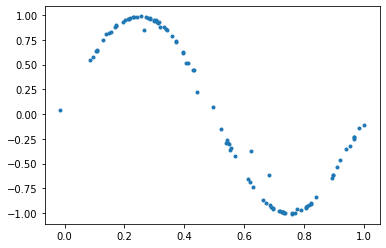

In [113]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")